# Executive Summary
Kiva is an international, nonprofit organization whose ultimate mission is to alleviate poverty through crowdfunded loans. Loans through Kiva are requested for a myriad of reasons including: to start or grow a business, to go to school, to access clean water or to simply repair a rickshaw to maintain a living. To date, Kiva has reached 2.6 million borrowers in 86 countries through 1.7 million lenders.   

To impact the greatest number of people, Kiva has established two working models: direct loans and partner loans. Direct loans are currently only available to U.S. residents and are made through Paypal. Partner loans, on the other hand, are adminstered through a Field Partner (local nonprofits or lending institutions) who will collect some interest. As mentioned by the Kiva Impact Team in the ongoing discussions, we are mostly concerned with the partner loans as they occur in rural and developing markets where interest in understanding borrower behavior is high. 

The partner loans follow a simple protocol:

1. The prospective borrower will meet with a Field Partner and apply for a loan;

2. The Field Partner will approve the loan and disberse funds right then;

3. The Field Partner will then upload loan details to Kiva's system; 

4. Kiva's pre-established network of volunteers will then edit and translate details as appropriate before going live on the website.

5. Once live, lenders will fund the loan in $25 increments until the amount is reached; 

6. When fundraising is complete, Kiva sends money to Field Partners;

7. Simultanesouly, borrowers (who received the money upfront before fundraising) are on a repayment schedule, often based on ability to pay. Payments are made to the Field Partner who sends the money back to the lenders through their Kiva accounts. 

8. At this point, lenders can choose to either fund another loan, donate the money to Kiva or withdraw their money completely. 

According to Kiva's website, 100% of every dollar loaned on Kiva will go to backing loans. Kiva is otherwsie supported by optional donations, grants and/or sponsers. 

As funding in rural and developing markets can be unstable, Kiva is intent on learning more about borrower behavior. Understanding the psychology and circumstance around these microfinanced loans will better help Kiva set investment priorities, help inform prospective lenders, and better understand communities to hopefully then expand to other countries in need. 

Today, our goal is to use data from Kiva's active loans along with some external data sources to best estimate the welfare level of borrowers based on shared economic and demographic characteristics. The idea is to connect features of a loan or product to poverty mapping datasets in as granular manner as possible. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import plotly

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler

In [2]:
%matplotlib inline
plotly.offline.init_notebook_mode(connected=True)

In [3]:
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_colwidth', 999)

# Load Datasets Into SQL Database

In [4]:
def csv_into_sql(csv_file, sql_table, conn):
    try:
        conn.cursor().execute("SELECT 1 FROM %s LIMIT 1" % sql_table)
    except sqlite3.OperationalError:
        data = pd.read_csv(csv_file)
        data.columns = [col.lower().replace(' ', '_') for col in data.columns]
        data.to_sql(sql_table, conn, if_exists="replace")

In [5]:
#Create connection to sql database
conn = sqlite3.connect("kiva.sqlite")

In [6]:
#Load kiva_loans csv into SQL Database if it does not exist
csv_into_sql('kiva_loans.csv', 'kiva_loans', conn)

In [7]:
#Load kiva_mpi_region_locations csv into SQL Database if it does not exist
csv_into_sql('kiva_mpi_region_locations.csv', 'kiva_locations', conn)

In [8]:
#Load loan_themes_by_region csv into SQL Database if it does not exist
csv_into_sql('loan_themes_by_region.csv', 'loan_theme_region', conn)

In [9]:
#Load loan_themes_by_region csv into SQL Database if it does not exist
csv_into_sql('loan_theme_ids.csv', 'loan_theme', conn)

# Quick Loan Statistics in Kiva Crowdfunded Countries

In [10]:
#Create table with total loan amount, average loan amount and number of loans per country
loan_total = pd.read_sql_query(
    """
    SELECT SUM(loan_amount) AS total_loan_amount, COUNT(DISTINCT kiva_loans.id) AS num_loans, \
        AVG(loan_amount) AS average, kiva_loans.country AS country, kiva_locations.ISO
    FROM kiva_loans
    INNER JOIN kiva_locations ON kiva_loans.country = kiva_locations.country
    WHERE kiva_loans.country IS NOT NULL
    GROUP BY kiva_loans.country
    ORDER BY num_loans ASC
    """, 
    conn
)
loan_total

,total_loan_amount,num_loans,average,country,ISO
0,180000.0,1,15000.000000,Mauritania,MRT
1,476000.0,2,7000.000000,Afghanistan,AFG
2,380000.0,2,10000.000000,Bhutan,BTN
3,9250.0,4,2312.500000,Vanuatu,VUT
4,420875.0,8,4046.875000,Namibia,NAM
5,225875.0,75,3011.666667,Somalia,SOM
6,798175.0,125,912.200000,Belize,BLZ
7,1141575.0,134,2839.738806,China,CHN
8,1088100.0,160,755.625000,South Sudan,SSD
9,426100.0,180,2367.222222,Thailand,THA


In [11]:
#Transform each column into a readable format for mapping
loan_total['num_loans_string'] = loan_total['num_loans'].map(lambda x: "{:,}".format(x))

loan_total['avg_loans_string'] = loan_total['average'].map(lambda x: "${:,}".format(round(x, 2)))

loan_total['total_loans_string'] = loan_total['total_loan_amount'].map(lambda x: "${:,}".format(x))

In [12]:
loan_total['text'] = loan_total['country'] + '<br>' + \
                                    'Average Loan:' + ' ' + loan_total['avg_loans_string']

data = [ dict(
        type = 'choropleth',
        locations = loan_total['ISO'],
        z = loan_total['total_loan_amount'],
        text = loan_total['text'], 
        #colorscale = 'Blues',
        colorscale = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']],

        reversescale = False,
        showlegend = True,
        colorbar = dict(
            #autotick = False,
            tick0= 0,
            tickprefix = '$',
            title = 'Total Funded <br>Amount (USD)'),
      ) ]

layout = dict(
    title = 'Total Loan Amounts in <br>Kiva Crowdfunded Countries',
    geo = dict(
        showframe = True,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
plotly.offline.iplot( fig, validate=False)

In [13]:
loan_total['text'] = loan_total['country'] + '<br>' + \
                                    'Average Loan:' + ' ' + loan_total['avg_loans_string']


data = [ dict(
        type = 'choropleth',
        locations = loan_total['ISO'],
        z = loan_total['num_loans'],
        text = loan_total['text'], 
        colorscale = 'Blues',
        #colorscale = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            #[0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']],

        reversescale = True,
        showlegend = True,
        colorbar = dict(
            #autotick = False,
            tick0= 0,
            #tickprefix = '$',
            title = 'Number of Loans <br>Funded'),
      ) ]

layout = dict(
    title = 'Number of Loans in <br>Kiva Crowdfunded Countries',
    geo = dict(
        showframe = True,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
plotly.offline.iplot( fig, validate=False)

# Kiva Loan Data Prep & Visualization

When a loan process is intiated, the loan is given a unique id number. In the kiva_loans.csv dataset, provided by the organizers, each observation is at the unique loan id level. In total, we have 671,205 loans in the kiva_loans.csv.

In [18]:
#Read in the data
kiva_loans = pd.read_sql_query("select * from kiva_loans;", conn)

In [23]:
kiva_loans = kiva_loans.set_index(keys = 'index')

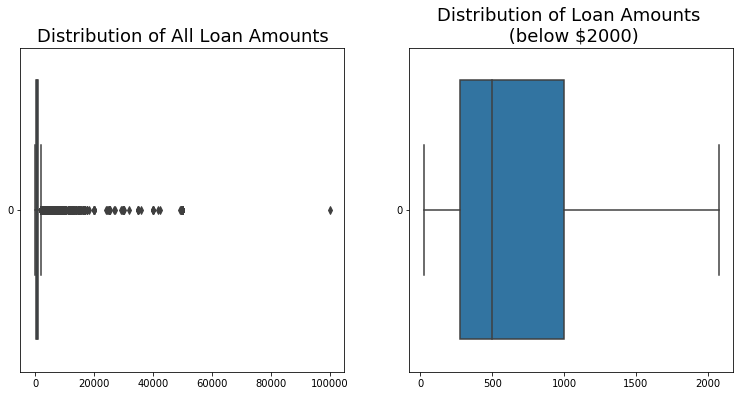

In [24]:
fig = plt.figure(figsize=(9,9))

axis1 = fig.add_axes([0,0,.5,.5])
axis1 = sns.boxplot(data = kiva_loans['loan_amount'], orient = 'h').set_title('Distribution of All Loan Amounts', size = 18);

axis2 = fig.add_axes([0.6,0,.5,.5])
axis2 = sns.boxplot(data = kiva_loans['loan_amount'], orient = 'h', showfliers=False).set_title('Distribution of Loan Amounts \n (below $2000)', size = 18);

Both of the graphs above depict the distribution of the 671,205 Kiva loans. The first graph gives us an overall picture while the second graph hones in on values less than \$2,000. From the first boxplot, we can see that past loans have ranged from as low \$0 to as high as \$100,000. Unfortunately, we cannot glean much more information than that aside from the fact that most points seem to be less than \$20,000. From the second plot, however, we have cut out the outliers in order to get a closer look of the distribution near the median. Accordingly we can see that most loans range from about \$250 to \$1,000 with a median value aroud \$500.

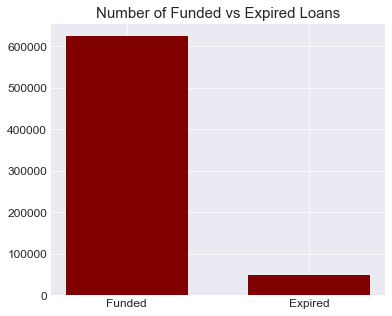

In [65]:
fig = plt.figure(figsize=(6,5))

funded = kiva_loans[kiva_loans['funded_amount'] >= kiva_loans['loan_amount']]
expired = kiva_loans[kiva_loans['funded_amount'] < kiva_loans['loan_amount']]

plt.bar(left = (0,0.3), height = (len(funded), len(expired)), width = 0.2, color = 'maroon', tick_label = ('Funded', 'Expired'))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Number of Funded vs Expired Loans", fontsize = 15);

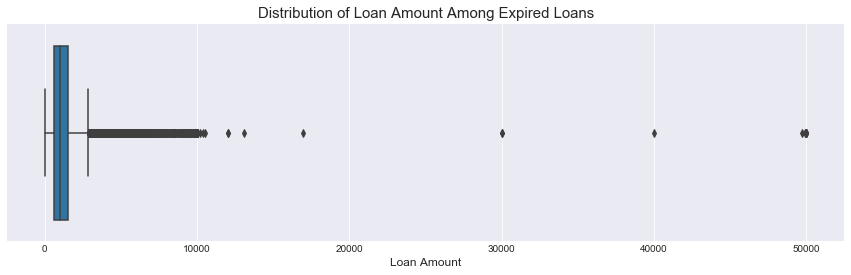

In [73]:
#Do expired loans have a realtionship with the loan amount?
plt.figure(figsize = (15,4))
sns.boxplot(x = expired['loan_amount'])
plt.xlabel("Loan Amount", fontsize = 12)
plt.title("Distribution of Loan Amount Among Expired Loans", fontsize = 15);

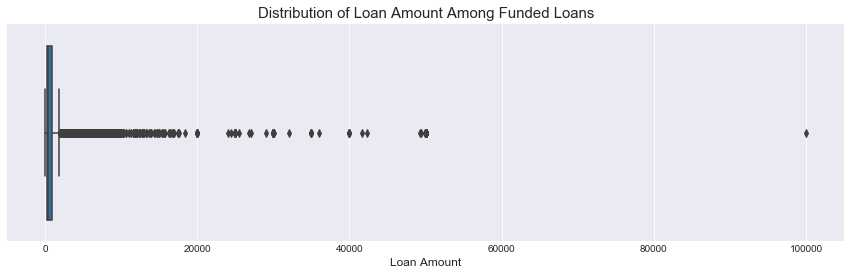

In [76]:
plt.figure(figsize = (15,4))
sns.boxplot(x = funded['loan_amount'])
plt.xlabel("Loan Amount", fontsize = 12)
plt.title("Distribution of Loan Amount Among Funded Loans", fontsize = 15);

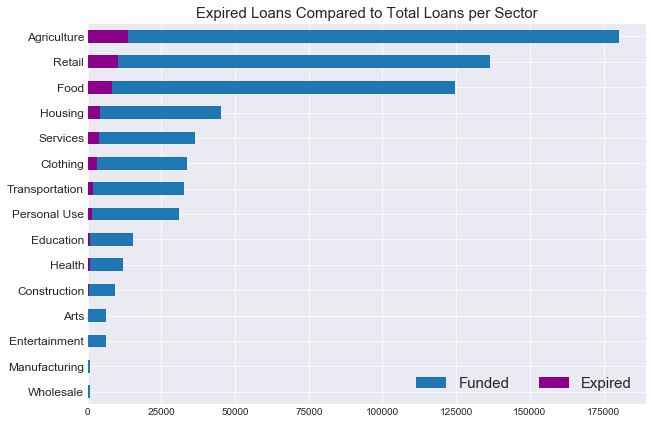

In [112]:
#Do funded vs expired loans vary by sector?
plt.figure(figsize= (10,7))
kiva_loans['sector'].value_counts().sort_values(ascending = True).plot(kind = 'barh', label = 'Funded')
expired['sector'].value_counts().sort_values(ascending = True).plot(kind = 'barh', color = 'darkmagenta', label = 'Expired')
plt.yticks(fontsize = 12)
plt.legend(ncol=2, loc="lower right", fontsize = 15)
plt.title("Expired Loans Compared to Total Loans per Sector", fontsize = 15);

When the funded amount is less than loan amount, that means that the loan was posted on Kiva, but was not fully funded. This is called expiration. In such cases, all of the money is refunded to any lenders and Kiva doesn't back the loan at all. As we are attempting to describe borrower behavior, it may be more appropriate to focus only on funded loans. Fortunately, as pictured above, expired loans make up a very small proportion of the data (about 7% in fact). 

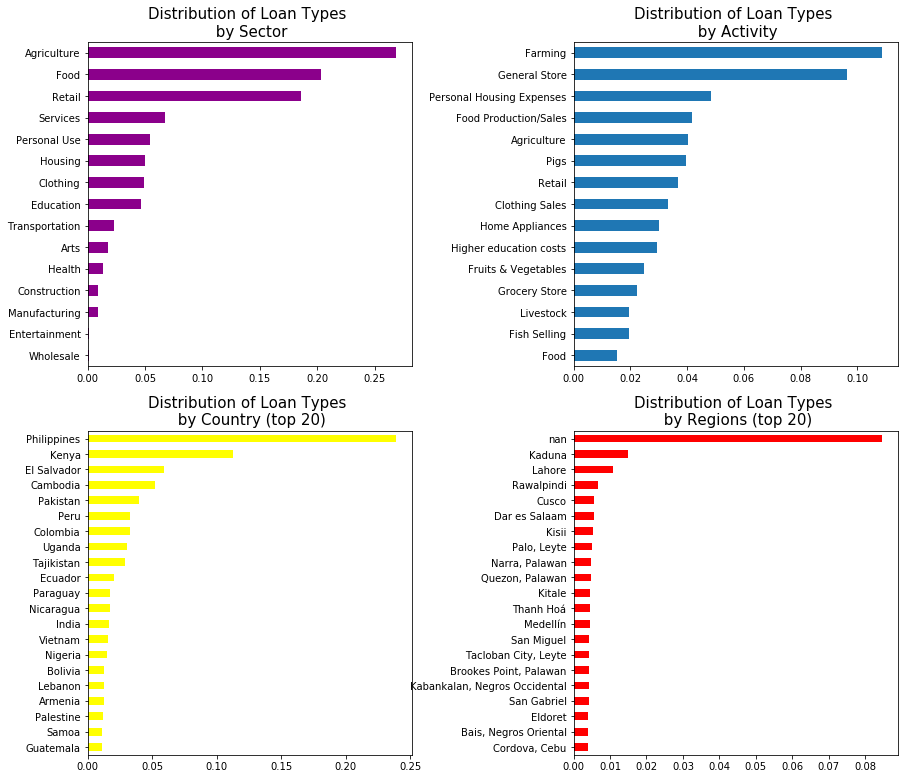

In [27]:
fig = plt.figure(figsize=(9,9))

#Distribution of Loans by Sector (Description of loan activity as shown to lenders)
axis1 = fig.add_axes([0,.6,.5,.5])
axis1 = kiva_loans['sector'].value_counts(normalize = True).sort_values(ascending = True).plot(kind = 'barh', color = 'darkmagenta')
axis1.set_title("Distribution of Loan Types \n by Sector", fontsize = 15);

#Distribution of Loans Activity Type 
axis2 = fig.add_axes([0.75,.6,.5,.5])
axis2 = kiva_loans['activity'].value_counts(normalize = True).sort_values(ascending = True)[-15:].plot(kind = 'barh')
axis2.set_title("Distribution of Loan Types \n by Activity", fontsize = 15);

#Distribution of Loans by Countries
axis3 = fig.add_axes([0,0,.5,.5])
axis3 = kiva_loans['country'].value_counts(normalize = True).sort_values(ascending = True)[-21:].plot(kind = 'barh', color = 'yellow')
axis3.set_title("Distribution of Loan Types \n by Country (top 20)", fontsize = 15);

#Distribution of Loans by Regions
axis4 = fig.add_axes([0.75,0,.5,.5])
axis4 = kiva_loans['region'].value_counts(normalize = True,dropna = False).sort_values(ascending = True)[-21:].plot(kind = 'barh', color = 'red')
axis4.set_title("Distribution of Loan Types \n by Regions (top 20)", fontsize = 15);

The above four plots give a quick visual of Kiva loans broken down by sector, activity, countries and regions. 
Sector descriptions are those lenders see when deciding whether to help fund a loan. It gives a broad description of what the money will be used for. As we can see, the three most popular loans include: Agriculture, Food and Retail--making up almost 65% of all loans. 

The plot in the top right breaks loans down by activity, which is simply a more granular description of what the loan was used for. While the chart only shows the top 15 activities, there are actually about 163 different categories. Among these, Farming and General Store were overwhelmingly present, representing about 20% of the data while all other categories made up 5% or below.

The plot in the bottom left breaks loans down by countries. Similar to what we saw on the map, the Philippines certainly dominates with over 20% of all loans. 

The bottom right plot, breaks loans down by region. Of all four, this is the most interesting as it seems to be missing a majority of its data at about 84%. As Kiva is particularly interested in more granular insights, it makes sense that they are missing most of the data for this category. It will be our job to infer these regions (if possible) moving forward. 

In [28]:
#Create columns with singular male, female or both label
gender_list = []
for row in kiva_loans['borrower_genders']:
    if row == None:
        gender_list.append('unknown')
    elif (' male' in row) & (' female' in row): 
        gender_list.append('both')
    elif 'female' in row:
        gender_list.append('female')
    elif 'male' in row:
        gender_list.append('male')   

In [29]:
kiva_loans['gender'] = gender_list

In [30]:
#Create column for number of borrowers
borrower_num = []
for row in kiva_loans['borrower_genders']:
    if row == None:
        borrower_num.append('unknown')
    else:
        borrower_num.append(len(row.split(' ')))

In [31]:
kiva_loans['number_of_borrowers'] = borrower_num

In [32]:
kiva_loans.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date,gender,number_of_borrowers
index,,,,,,,,,,,,,,,,,,,,,,
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,None,female,irregular,2014-01-01,female,1
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used in their business.,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,None,"female, female",irregular,2014-01-01,female,2
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another one to rent out as a source of income,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01,female,1
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variety of new embroidery materials.,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,None,female,irregular,2014-01-01,female,1
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,None,female,monthly,2014-01-01,female,1


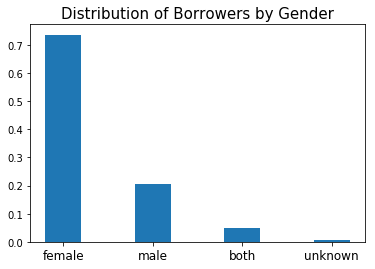

In [33]:
plt.bar(left = np.arange(len(kiva_loans['gender'].value_counts(normalize = True))), \
        height = kiva_loans['gender'].value_counts(normalize = True), width = 0.4)
plt.xticks(np.arange(4), list(kiva_loans['gender'].value_counts(normalize = True).keys()), fontsize = 12)
plt.title("Distribution of Borrowers by Gender", fontsize = 15);

We overwhelmingly see an all-female borrower skew. As we continue our analysis, it may be appropriate to check male to female population per country and their corresponding poverty index (if a granular one exists).

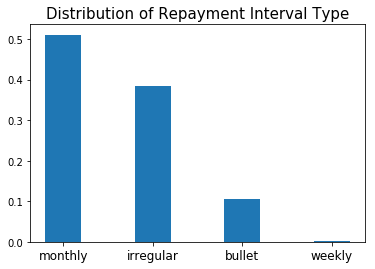

In [34]:
#Plot repayment interval
plt.bar(left = np.arange(len(kiva_loans['repayment_interval'].value_counts(normalize = True))), \
        height = kiva_loans['repayment_interval'].value_counts(normalize = True), width = 0.4)
plt.xticks(np.arange(4), list(kiva_loans['repayment_interval'].value_counts(normalize = True).keys()), fontsize = 12)
plt.title("Distribution of Repayment Interval Type", fontsize = 15);

In [35]:
#Do repayment interval types differ by sector?
repayment_sector = pd.read_sql_query(
    """
    SELECT sector, repayment_interval, COUNT(repayment_interval) AS Count
    FROM kiva_loans
    GROUP BY repayment_interval, sector
    ORDER BY sector ASC
    """, 
    conn
)
repayment_sector

,sector,repayment_interval,Count
0,Agriculture,bullet,43963
1,Agriculture,irregular,47524
2,Agriculture,monthly,88776
3,Agriculture,weekly,39
4,Arts,bullet,1475
5,Arts,irregular,4636
6,Arts,monthly,5934
7,Arts,weekly,15
8,Clothing,bullet,1048
9,Clothing,irregular,13559


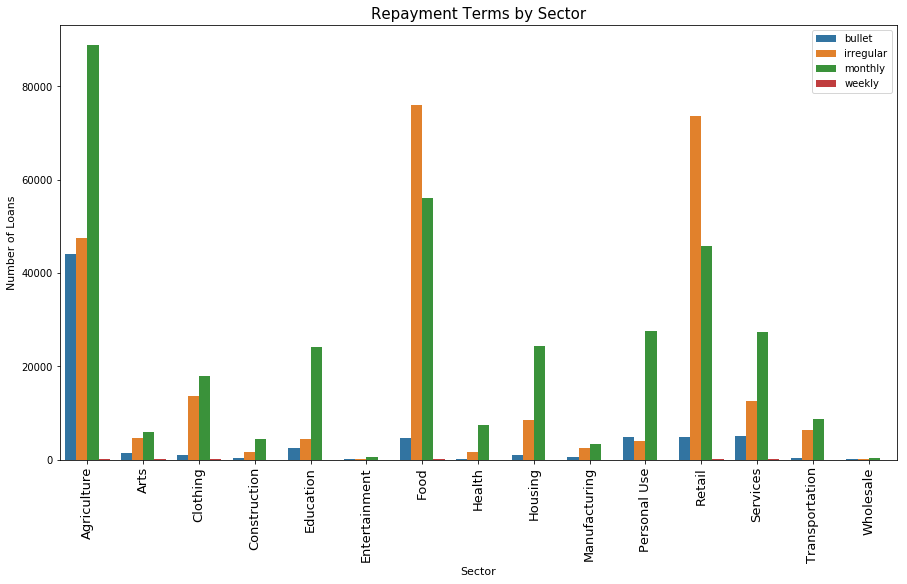

In [36]:
plt.figure(figsize = (15,8))
sns.barplot(x='sector', y='Count', hue='repayment_interval', data=repayment_sector)
plt.xticks(fontsize = 13, rotation = 90)
plt.legend(loc = 'upper right')
plt.title("Repayment Terms by Sector", fontsize = 15)
plt.xlabel("Sector", fontsize = 11)
plt.ylabel("Number of Loans", fontsize = 11);

There are four categories of repayment terms in our kiva_loans dataset: weekly, monthly, irregular or bullet. In our first graph, where we viewed the distribution of repayment intervals independently, we noted that monthly payments were by far the most common method. When we plotted repayment terms by sector, we still see that monthly is the most popular method with the exception of 'food' and 'retail', both of which prefer irregular.  

In [37]:
#Label the quarter the loan was asked for
quarter = []
for row in kiva_loans['date']: 
    month = int(row.split('-')[1])
    
    if (month >= 1) & (month <= 3):
        quarter.append('1')
    
    elif (month >= 4) & (month <= 6):
        quarter.append('2')
        
    elif (month >= 7) & (month <= 9):
        quarter.append('3')
    
    elif (month >= 10) & (month <= 12):
        quarter.append('4')
        

In [38]:
kiva_loans['quarter_loan_posted'] = quarter

In [39]:
kiva_loans.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date,gender,number_of_borrowers,quarter_loan_posted
index,,,,,,,,,,,,,,,,,,,,,,,
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,None,female,irregular,2014-01-01,female,1,1
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used in their business.,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,None,"female, female",irregular,2014-01-01,female,2,1
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another one to rent out as a source of income,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01,female,1,1
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variety of new embroidery materials.,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,None,female,irregular,2014-01-01,female,1,1
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,None,female,monthly,2014-01-01,female,1,1


In [40]:
#Create dictionary of the number of loans per quarter
num_loans_time ={}

for year in ['2014', '2015','2016', '2017']:
    for quarter in range(1, 5):
        num = len(kiva_loans[(kiva_loans['date'].str.contains(year)) & \
                             (kiva_loans['quarter_loan_posted']==str(quarter))])
        
        num_loans_time["%s Q%d" % (year, quarter)] = num

##Remove 2017 Q4 since it does not exist in our dataset
del num_loans_time['2017 Q4']

##For graphing purposes, we will also remove 2017 Q3 since there is only a month's worth of data
del num_loans_time['2017 Q3']

#Create dictionary of the number of active countries per quarter
country_loans_time ={}

for year in ['2014', '2015','2016', '2017']:
    for quarter in range(1, 5):
        countries = kiva_loans[(kiva_loans['date'].str.contains(year)) & \
                             (kiva_loans['quarter_loan_posted']==str(quarter))]['country'].nunique()
        
        country_loans_time["%s Q%d" % (year, quarter)] = countries

##Similar to above, we will remove 2017 Q4 since it does not exist in our dataset
del country_loans_time['2017 Q4']

##Also similar to above, we will remove 2017 Q3 since there is only a month's worth of data
del country_loans_time['2017 Q3']

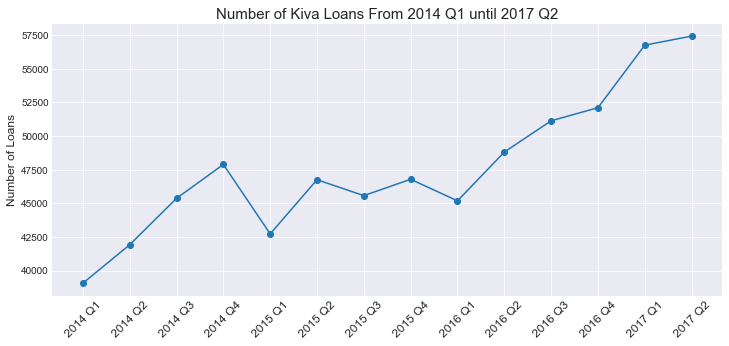

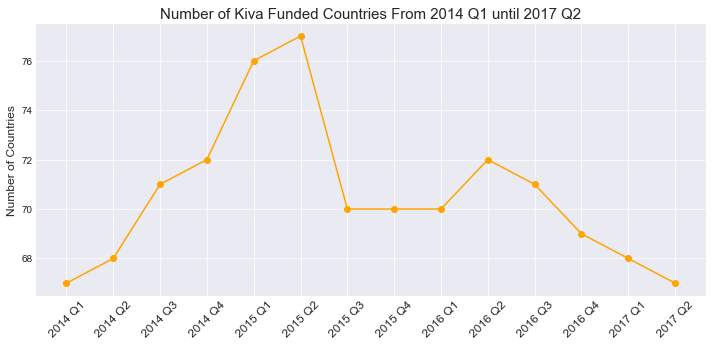

In [41]:
sns.set_style('darkgrid')
plt.figure(figsize = (12,5))
plt.plot(np.arange(len(num_loans_time)), list(num_loans_time.values()), marker='o')
plt.xticks(np.arange(len(num_loans_time)), list(num_loans_time.keys()), fontsize = 12, rotation = 45)
plt.ylabel("Number of Loans", fontsize = 12)
plt.title("Number of Kiva Loans From 2014 Q1 until 2017 Q2", fontsize = 15);

plt.figure(figsize = (12,5))
plt.plot(np.arange(len(country_loans_time)), list(country_loans_time.values()), marker='o', color = 'orange')
plt.xticks(np.arange(len(country_loans_time)), list(country_loans_time.keys()), fontsize = 12, rotation = 45)
plt.ylabel("Number of Countries", fontsize = 12)
plt.title("Number of Kiva Funded Countries From 2014 Q1 until 2017 Q2", fontsize = 15);

From the first graph, we can clearly see that the number of loans generally increased between 2014 Q1 and 2017 Q2. An exception to this trend, however, seems to occur around 2015. Not only was there a sharp drop from the end of 2014 to the beginning of 2015, but even once the numbers increased in Q2 they seemed to remain relatively stagnant. This could have been due to a change in Kiva's policies or (from a more global perspective) could reflect a change in the economy that may have prevented lenders from funding loans.

From the second graph, we can see a lot of fluctuation in the number of active countries at a given point in time. Similar to the number of loans graph, we can see that 2014 saw a lot of growth in the number of active countries and again 2015 seemed to remain relatively stagnant. Where the graphs seem to diverge, however, is around 2016. While the number of loans continue to increase from 2016 Q1 until 2017 Q2, the number of active countires actually decreases pretty significantly. While this could be due to a number of outside factors, this tells me that the increased number of loans were being dispensed to less countries.

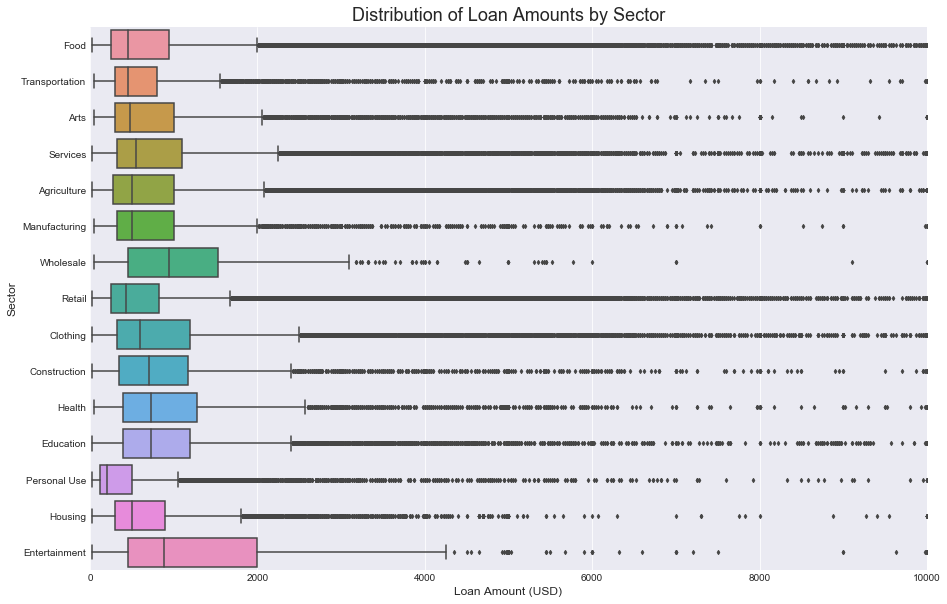

In [42]:
#Does loan amount change with sector?
plt.figure(figsize = (15, 10))
sns.boxplot(x = 'loan_amount', y = 'sector', data = kiva_loans, fliersize = 3);
plt.xlim(0, 10000)
plt.xlabel("Loan Amount (USD)", fontsize = 12)
plt.ylabel("Sector", fontsize = 12)
plt.title("Distribution of Loan Amounts by Sector", fontsize = 18);

Loan amounts do slightly differ by sector. According to the boxplots above, the sector with the lowest median and variation falls under personal use while the sector with the highest median and variation falls under entertainment. Each sector also has a myriand of outliers. For readability, the cut off point was set at \$10,000 but the outliers continue up until $100,000. 

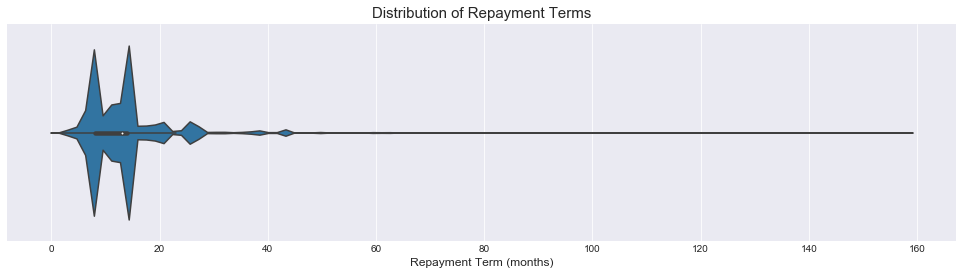

In [43]:
#How long does it take to repay a loan?
plt.figure(figsize = (17,4))
sns.violinplot(kiva_loans['term_in_months'])
plt.xlabel("Repayment Term (months)", fontsize = 12)
plt.title("Distribution of Repayment Terms", fontsize = 15);

There seem to be two waves of common repayment terms: the first around 8 months and the second around the mean of about 13 months. Terms can be set as high as almost 160 months (almost 13 years) but this is an extreme outlier. 

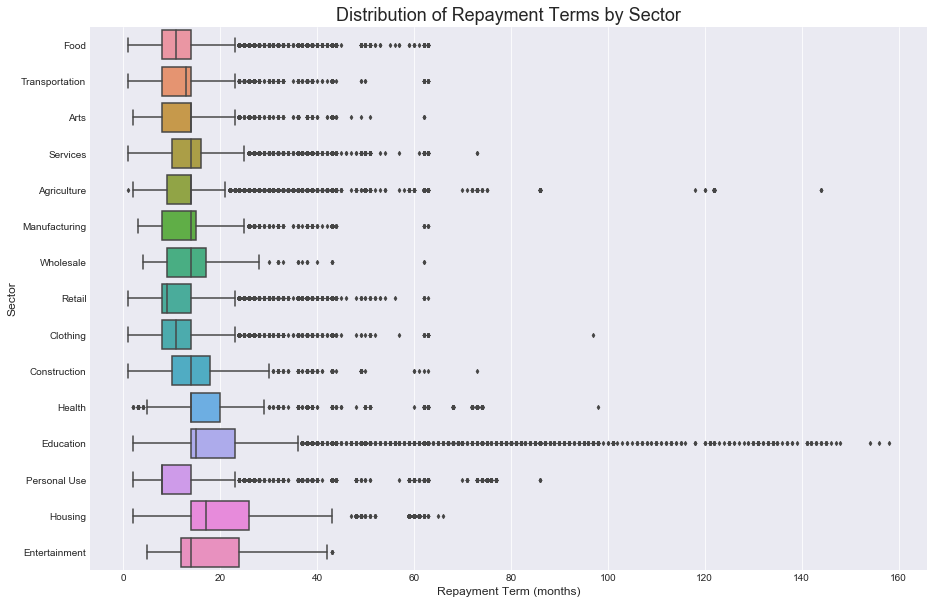

In [44]:
#Do repayment terms differ by sector? 
plt.figure(figsize = (15, 10))
sns.boxplot(x = 'term_in_months', y = 'sector', data = kiva_loans, fliersize = 3);
plt.xlabel("Repayment Term (months)", fontsize = 12)
plt.ylabel("Sector", fontsize = 12)
plt.title("Distribution of Repayment Terms by Sector", fontsize = 18);

As we would expect, repayment terms vary widely by sector possibly due to volatility of the activity or possibly due to a borrower's ability to pay. With the exception of education, housing and entertainment, most repayment terms fall below 20 months. We see the most variation in education, with terms almost as high as 160 months (about 13 years).

In [163]:
#Aggregate payment type
#Calculate post time
#Find conversion rate
#If done over a span of years, find inflation rate
#Label quarter loan was asked for/fulfilled

In [88]:
#Datasets to bring in (prob from World Bank): 
#poverty index
#education levels
#male/female populatino ratios
#economic situation

In [268]:
kiva_loc = pd.read_csv("kiva_mpi_region_locations.csv")
kiva_loc.head()

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.734772,70.811995
1,"Badghis, Afghanistan",AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)",35.167134,63.769538
2,"Baghlan, Afghanistan",AFG,Afghanistan,Baghlan,South Asia,0.300,"(35.8042947, 69.2877535)",35.804295,69.287754
3,"Balkh, Afghanistan",AFG,Afghanistan,Balkh,South Asia,0.301,"(36.7550603, 66.8975372)",36.755060,66.897537
4,"Bamyan, Afghanistan",AFG,Afghanistan,Bamyan,South Asia,0.325,"(34.8100067, 67.8212104)",34.810007,67.821210


In [233]:
#Unique by id for loan
loan_theme_id = pd.read_csv("loan_theme_ids.csv")
loan_theme_id.head()

,id,Loan Theme ID,Loan Theme Type,Partner ID
0,638631,a1050000000skGl,General,151.0
1,640322,a1050000000skGl,General,151.0
2,641006,a1050000002X1ij,Higher Education,160.0
3,641019,a1050000002X1ij,Higher Education,160.0
4,641594,a1050000002VbsW,Subsistence Agriculture,336.0
